In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = [20, 10]
df = pd.read_csv("data/corsair-31-003606.csv")
df.describe()

,dutyCycle,rpm
count,1010.000000,1010.000000
mean,50.000000,1539.623762
std,29.169203,631.849941
min,0.000000,780.000000
25%,25.000000,780.000000
50%,50.000000,1560.000000
75%,75.000000,2100.000000
max,100.000000,4260.000000


## Question 1: Is there a relationship between the duty cycle and the speed?
In order to answer this question, we create a scatter plot of the dataset. This way, we can get a look
on how the two variables depend on each other and how good of a measure a polynomic function would be.
The fan in the first test is manufactured by Corsair and has the model number `31-003606`. Due to the fact, that this fan is no longer in production, we have a limited amount of information on hand. Allthough, based on our dataset, we can assume that it is rated for speeds between `700rpm` and `2700rpm`.
If there was such a relationship, we would expect to se bubbles of ten datapoints for every value of the duty cycle.



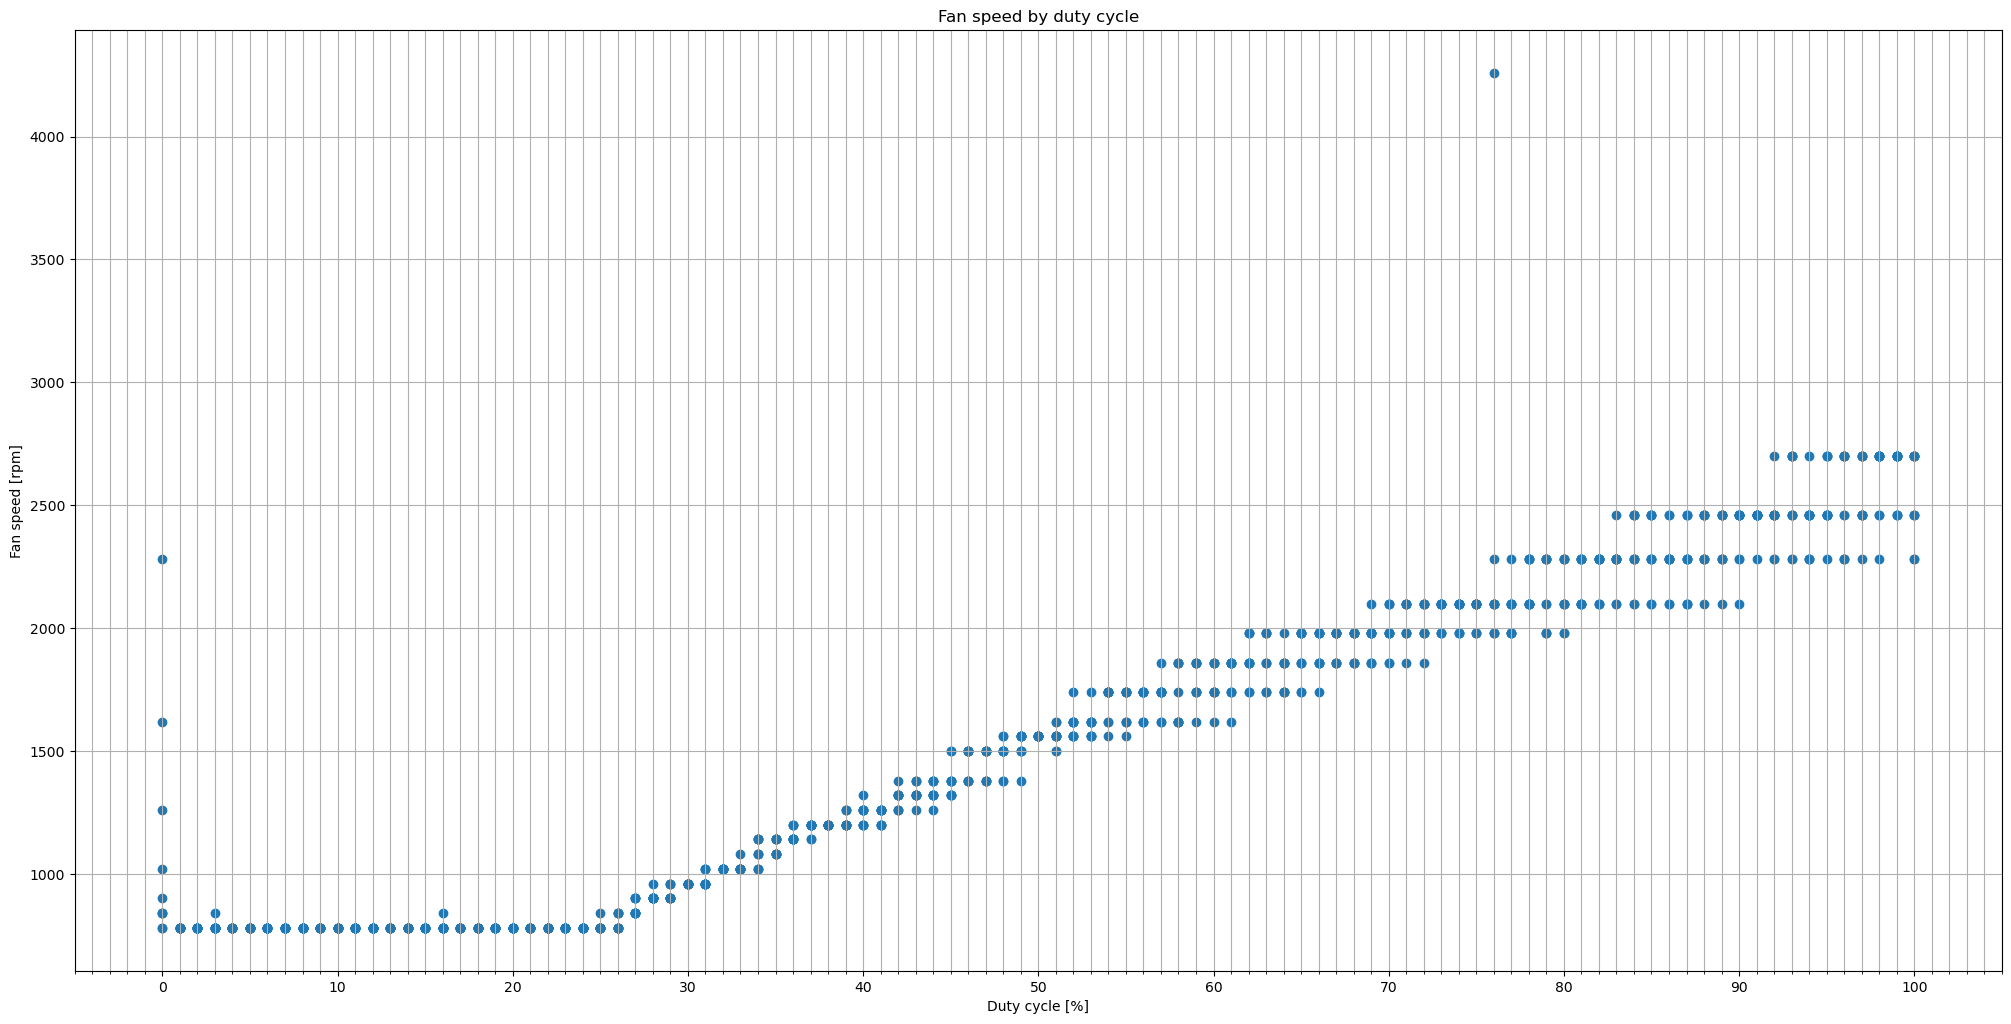

In [3]:
fig, ax = plt.subplots()

fig.tight_layout()
ax.scatter(df.dutyCycle, df.rpm)

plt.xlabel("Duty cycle [%]")
plt.ylabel("Fan speed [rpm]")
ax.set_title("Fan speed by duty cycle")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="both")



If we look at the chart, we can see that those groups exist in reality. We can also show, that exept for a duty cycle of `0%`, there are not more that three different value for a constant duty cycle. Furthermore, we can see, that the range where of fan speed for a given duty cycle widens as the duty cycle increases. To quantify this, we want to aggregate the measurement by duty cycle to get the mean speed alongside with the standard deviation.

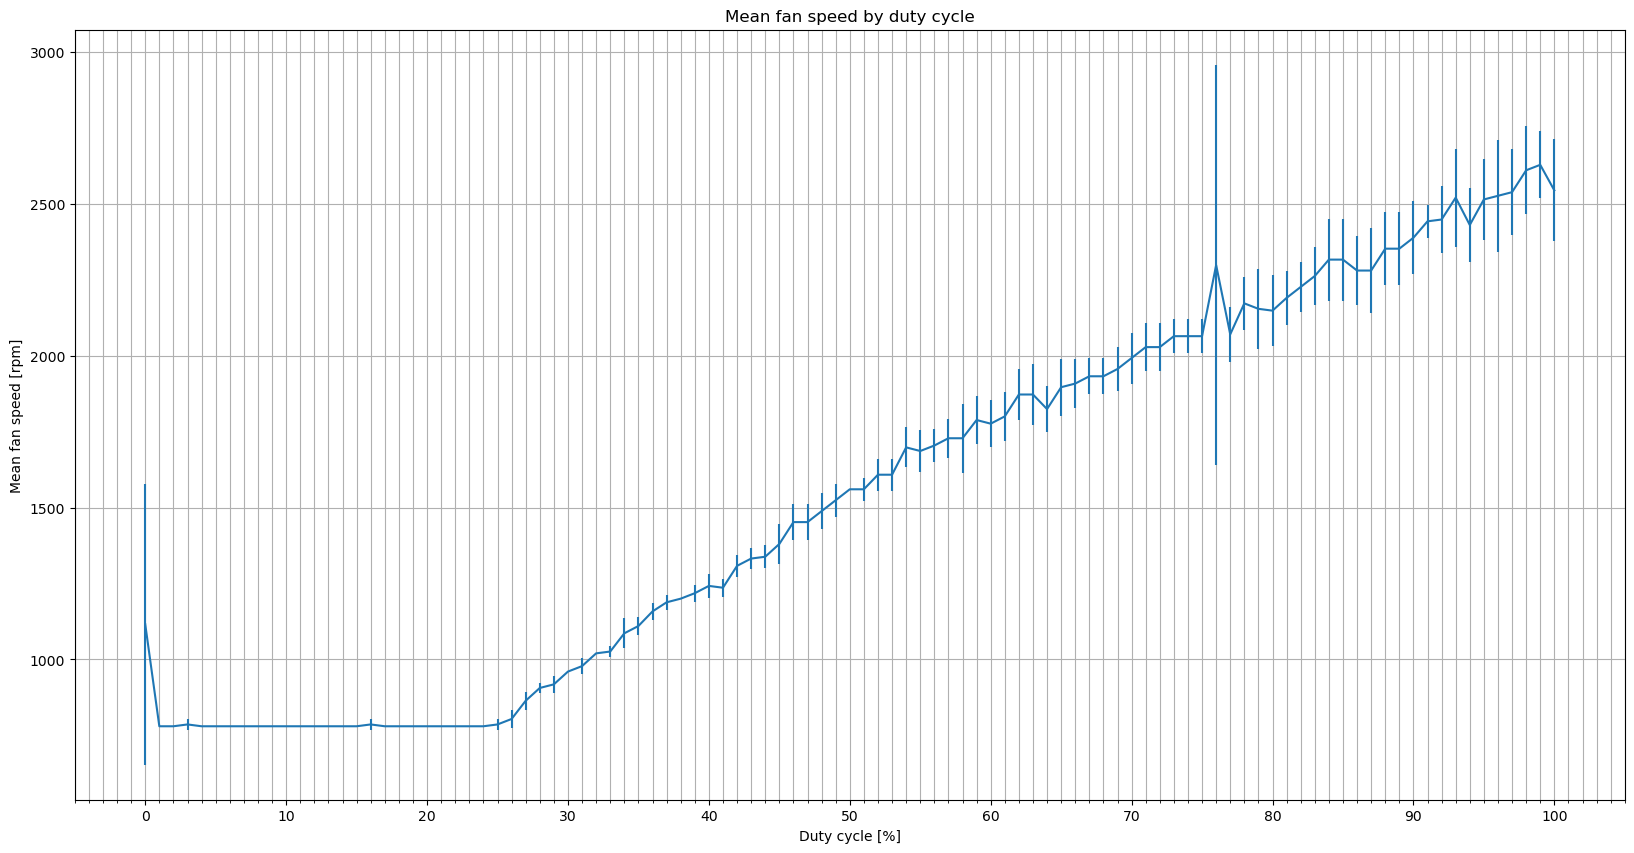

In [4]:
def std(x): 
    return np.std(x)

aggregated_df = df.groupby("dutyCycle").aggregate({"rpm": ["mean", std]})["rpm"]

fig, ax = plt.subplots()
ax.errorbar(aggregated_df.index, aggregated_df["mean"], aggregated_df["std"], )

plt.xlabel("Duty cycle [%]")
plt.ylabel("Mean fan speed [rpm]")
ax.set_title("Mean fan speed by duty cycle")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="both")


From the plot, we can tell, that the mean operation works quite well except for a duty cycle of `0%` and `76%`. Additionally, there seems to be lower bound for the fan speed at about `500rpm`.

To answer the initial question, we can say that there is a linear relationship between the duty cycle and the fan speed which has a lower bound of about `500rpm`.

## Question 2: Can we synthesize a table or mathematic function that maps a fan speed to the required duty cycle?
From what we've seen for the previous question, a table would not be appropriate. Instead, we try to synthesize a mathematic function by applying a linear regression. In order to take the lower bound into account, we apply the linear regression only on the data set for duty cycles above `24%`. When we look at the data directly, we can see that the lower bound is actually at `780rpm`.

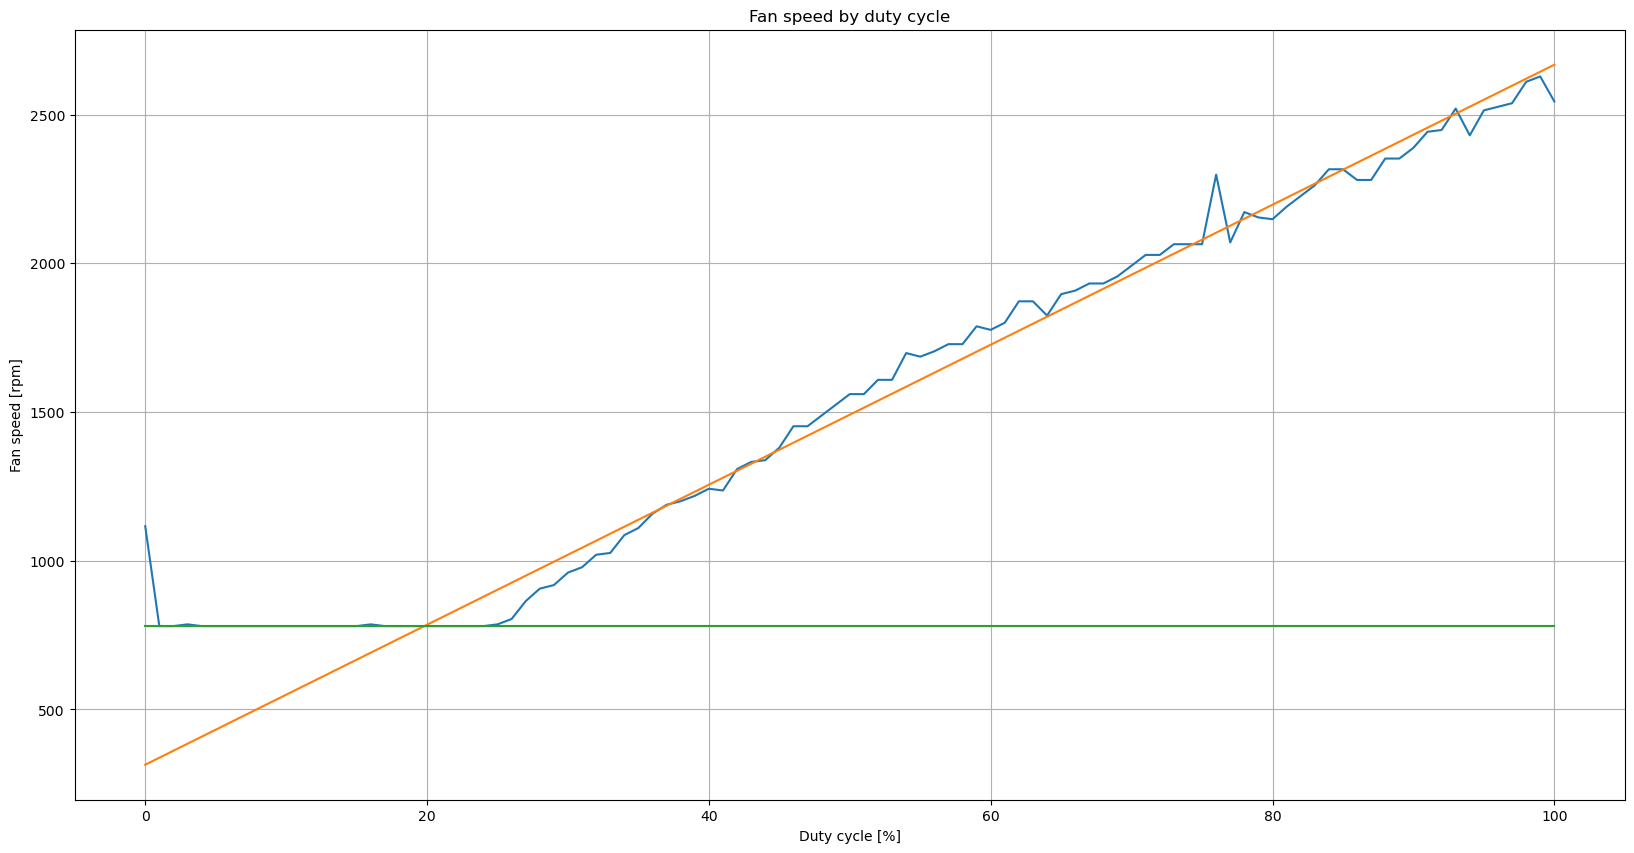

In [5]:
df_aboveLowerBound = df[df["dutyCycle"] > 24]

regression = linear_model.LinearRegression()
x = np.array(df_aboveLowerBound["dutyCycle"]).reshape(-1, 1) 
y = np.array(df_aboveLowerBound["rpm"]).reshape(-1, 1) 
regression.fit(x, y)

prediction_x = np.arange(101).reshape(-1, 1)
prediction_y = regression.predict(prediction_x)

fig, ax = plt.subplots()
ax.plot(aggregated_df.index, aggregated_df["mean"])
ax.plot(prediction_x, prediction_y)
ax.plot(prediction_x, np.repeat(780, 101))

plt.xlabel("Duty cycle [%]")
plt.ylabel("Fan speed [rpm]")
ax.set_title("Fan speed by duty cycle")

ax.grid(which="both")


To convert this regression into a function, we need to know 
* the equation of the orange regression line
* the intersection point of the green line representing the lower bound and the orange regression line

The regression equation is linear and therefore is of the shape `s(d) = md + b` with `s(d)` beeing the speed and `d`beeing the duty cycle. The constant values of `m` (slope) and `b` (intercept) can be obtained from the regression model like so:

In [6]:
print(f"m = {regression.coef_[0]}")
print(f"b = {regression.intercept_}")

m = [23.53369788]
b = [314.06493506]


Therefore the regression equation is `s(d) = 23.53369788 * d + 314.06493506`. As the value of the green line is per definition a constant of `780`, we can calculate the interception using:

`780 = 23.53369788 * d + 314.06493506`

`= 780 - 314.06493506`

`= (780 - 314.06493506) / 23.53369788`

`= 19.7986337428`

As of that, the interception is at (19.7986337428, 780). With those two bits of information, we can synthesize a function to convert a duty cycle to an expected fan speed and vice versa.

```dart
double dutyCycleToSpeed(double dutyCycle) {
    if (dutyCycle < 19.7986337428) {
        return 780;
    }

    return 23.53369788 * dutyCycle + 314.06493506;
}

double speedToDutyCycle(double fanSpeed) {
    if (fanSpeed <= 780) {
        // We can set the duty cycle arbitrarily between 0 and 19.7986337428. So to enable possible 
        // performance optimizations, we set it to 0.
        return 0;
    }

    final dutyCycle = (fanSpeed - 314.06493506) / 23.53369788;
    return max(0, dutyCycle);
}
```

With that being said, the second question is answered.

## Question 3: Is this table or function specific to the minimum and maximum speed of the fan?
To answer this third question, we need to gather test results on a second fan. The second fan in this study will be a !(https://noctua.at/en/nf-a12x15-pwm)[Noctua NF-A12x15-PWM]. This fan differs in the manufacturer, the minimum speed and the maximum speed. Noctua states in the !(https://noctua.at/en/nf-a12x15-pwm/specification)[specifications], that the speed is in the range between `450rpm` and `1850rpm`.

To see whether the findings in this data set are applicable to other fans, we have to repeat the tests above with the new data set.

In [8]:
df = pd.read_csv("data/nf-a12x15pwm.csv")
df.describe()

,dutyCycle,rpm
count,1010.000000,1010.000000
mean,50.000000,977.405941
std,29.169203,548.147980
min,0.000000,0.000000
25%,25.000000,540.000000
50%,50.000000,1020.000000
75%,75.000000,1500.000000
max,100.000000,1860.000000


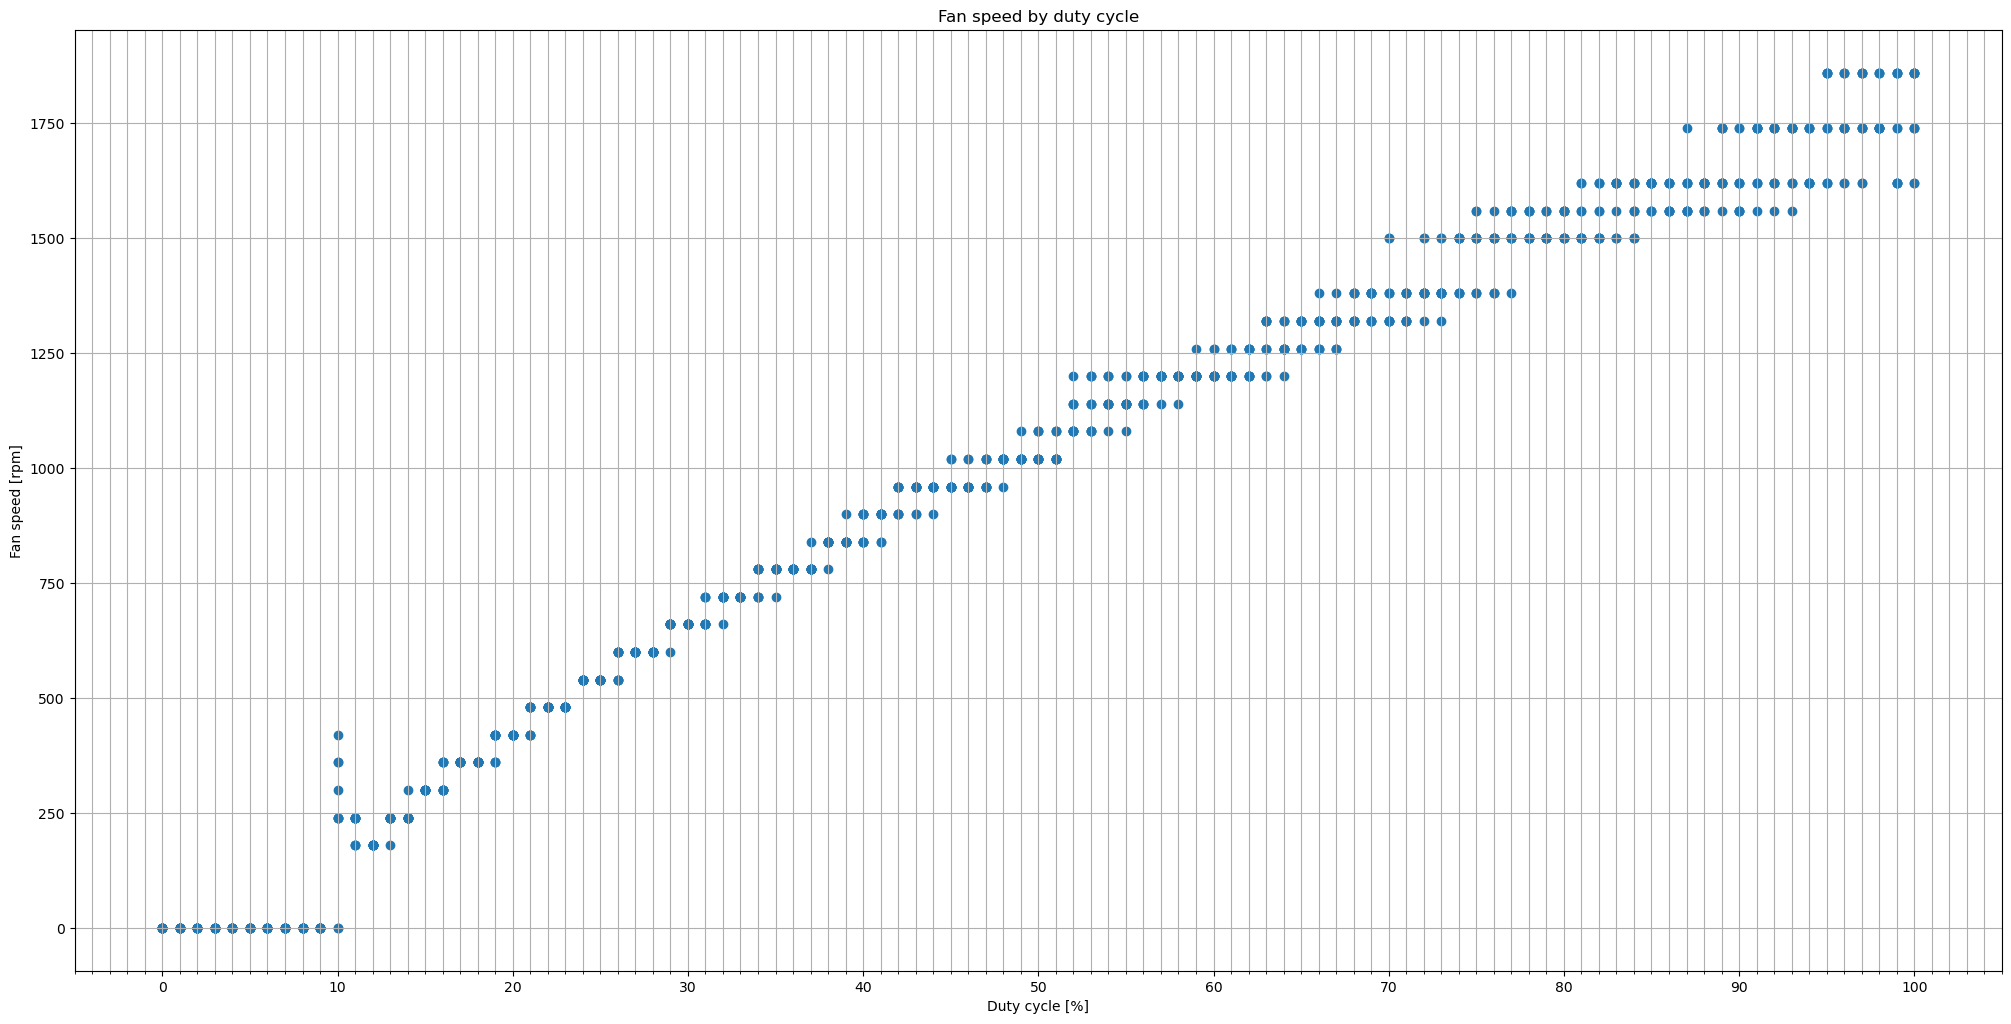

In [9]:
fig, ax = plt.subplots()

fig.tight_layout()
ax.scatter(df.dutyCycle, df.rpm)

plt.xlabel("Duty cycle [%]")
plt.ylabel("Fan speed [rpm]")
ax.set_title("Fan speed by duty cycle")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="both")

We can see, that the shapes match each other allthough, we have completely different values.

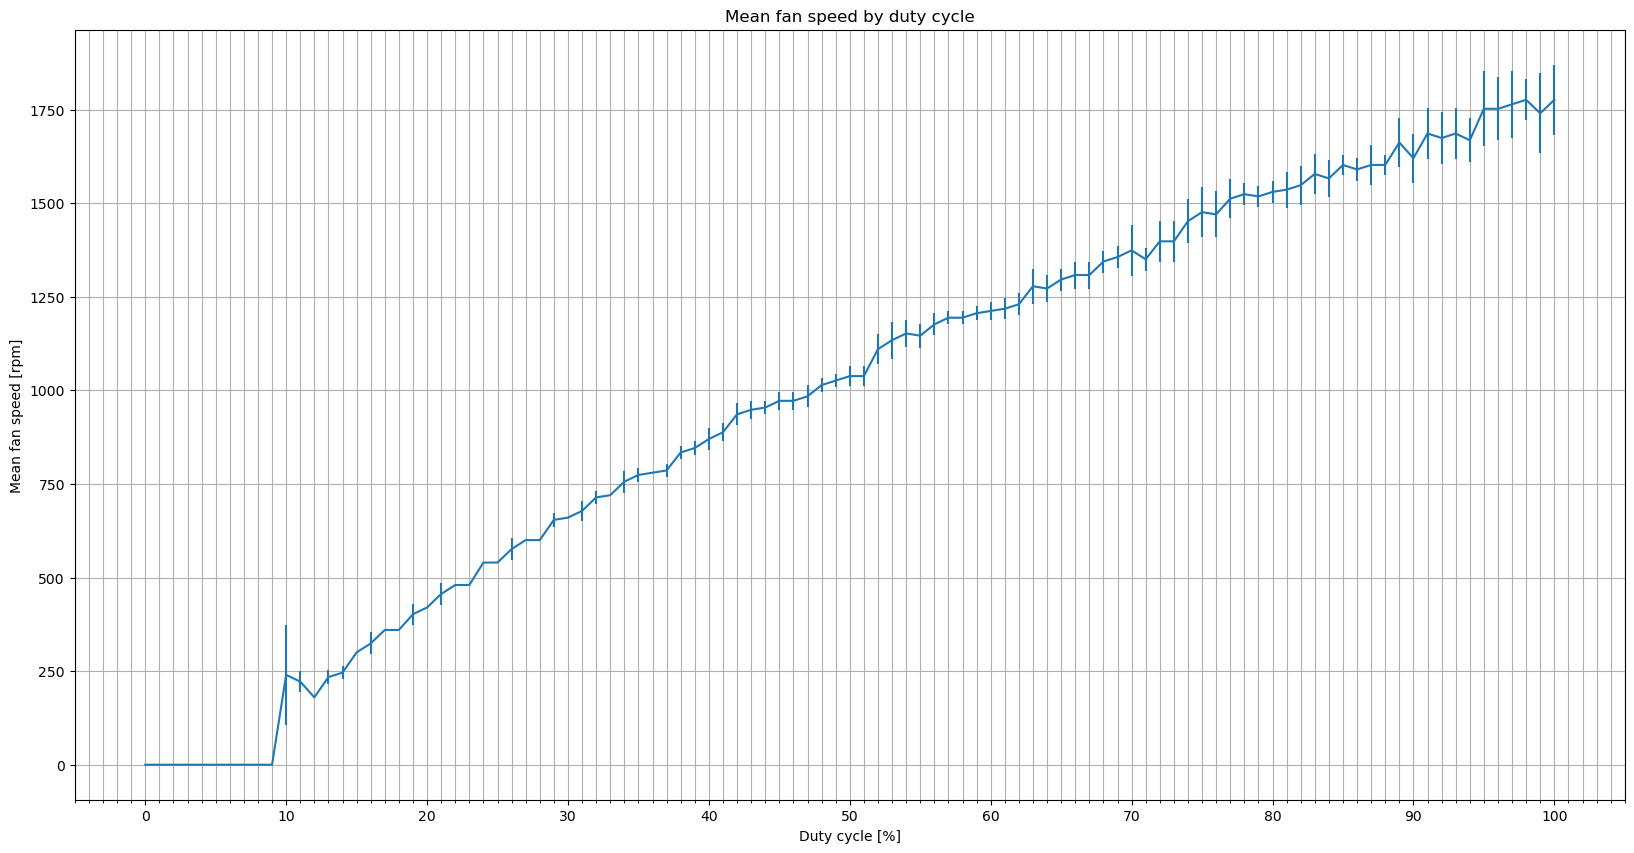

In [10]:
def std(x): 
    return np.std(x)

aggregated_df = df.groupby("dutyCycle").aggregate({"rpm": ["mean", std]})["rpm"]

fig, ax = plt.subplots()
ax.errorbar(aggregated_df.index, aggregated_df["mean"], aggregated_df["std"], )

plt.xlabel("Duty cycle [%]")
plt.ylabel("Mean fan speed [rpm]")
ax.set_title("Mean fan speed by duty cycle")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="both")

The same goes for that chart. It differs in the values and has fewer outliers. We can see, that the fan starts spinning at a duty cycle of `10%`. The speed at that point is about `240rpm`.

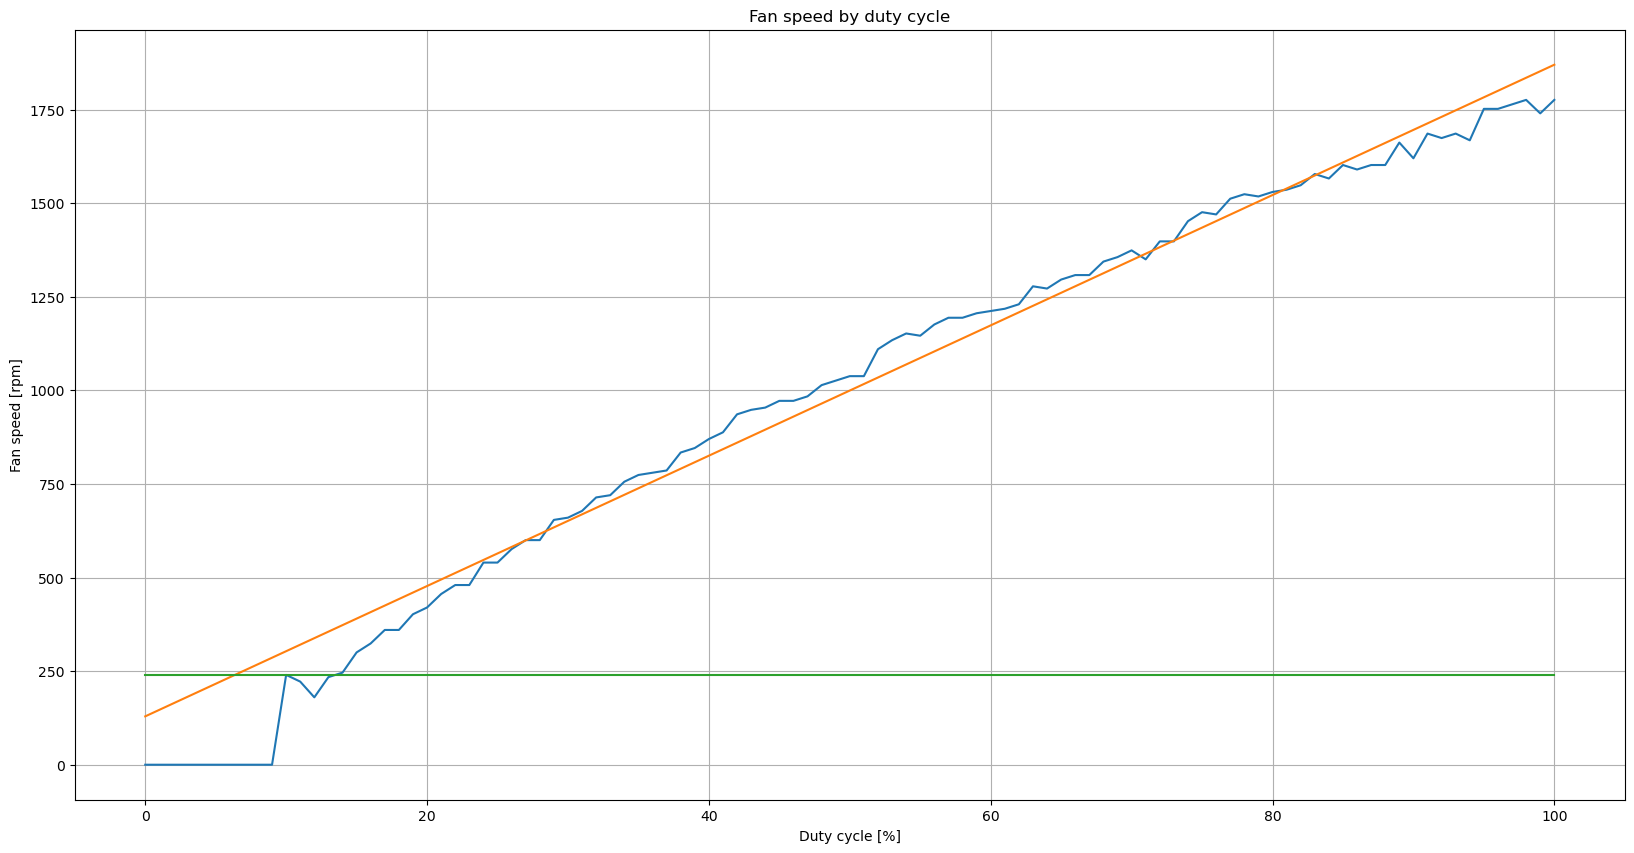

In [13]:
df_aboveLowerBound = df[df["dutyCycle"] > 11]

regression = linear_model.LinearRegression()
x = np.array(df_aboveLowerBound["dutyCycle"]).reshape(-1, 1) 
y = np.array(df_aboveLowerBound["rpm"]).reshape(-1, 1) 
regression.fit(x, y)

prediction_x = np.arange(101).reshape(-1, 1)
prediction_y = regression.predict(prediction_x)

fig, ax = plt.subplots()
ax.plot(aggregated_df.index, aggregated_df["mean"])
ax.plot(prediction_x, prediction_y)
ax.plot(prediction_x, np.repeat(240, 101))

plt.xlabel("Duty cycle [%]")
plt.ylabel("Fan speed [rpm]")
ax.set_title("Fan speed by duty cycle")

ax.grid(which="both")

For the new fan, the parameters of the regression line change as follows:

In [14]:
print(f"m = {regression.coef_[0]}")
print(f"b = {regression.intercept_}")

m = [17.40735444]
b = [129.18815117]


This changes the regression equation to `s(d) = 17.40735444 * d + 129.18815117`. While the green line becomes to a constant at `240`, which changes the interception to:

`240 = 17.40735444 * d + 129.18815117`

`= 240 - 129.18815117`

`= (240 - 129.18815117) / 17.40735444`

`= 6.3658064304`

As of that, the interception is at (6.3658064304, 240). With those two bits of information, we can update the two function to.

```dart
double dutyCycleToSpeed(double dutyCycle) {
    if (dutyCycle < 6.3658064304) {
        return 0;
    }

    return 17.40735444 * dutyCycle + 129.18815117;
}

double speedToDutyCycle(double fanSpeed) {
    if (fanSpeed <= 240) {
        // We can set the duty cycle arbitrarily between 0 and 6.3658064304. So to enable possible 
        // performance optimizations, we set it to 0.
        return 0;
    }

    final dutyCycle = (fanSpeed - 129.18815117) / 17.40735444;
    return max(0, dutyCycle);
}
```

With that information set, there are two possible ways to handle the difference: 

1. Find a relationship two calculate the necessary numbers based on the fan specification
2. Employ a calibration mechanism to find the necessary numbers empirically

Because a relationship as of the first approach is not guaranteed to exists and would potentially be difficult to find, we'll use the second path for the matters of this project.

So to answer this question, we assume the answer to be no.

## Question 4: Is this table or function specific to the type of fan?
This question is omitted because of the assumptions in quesition 3.